Yule Process: 

It's a Poisson process for simulation of the population $X(t)$.

It's a continuous-time Markov chain with transition probabilities:

$$P(X(t+\Delta t)-X(t)=1)= b\,X(t)^{d}\Delta t$$

$$P(X(t+\Delta t)-X(t)=0)= 1-b\,X(t)^{d}\Delta t$$ 

We call $\nu = b\,n^{d}$ as the rate of the change. If $d=1$,
then we have linear growth. It can be proved that if $d>1$, then the population explodes in a finte time; in other words, we will have infintely many jumps in a finte time. 

Simulation of Yule process can be done using two different techniques: Sampling of time increments and tau-leaping. In the the first method, we use the fact that waiting time (sojurn time) until the next jump in the population, when the current population is $n$, is exponentially distributed with parameter $\lambda_{n} = b\,n^{d}$ and hence we can sample the time incerements using these exponential distributions. 

In the next cell, we have simulated the Yule process with inital population $X_{0}=1$. We have simulated until a max population $N=1000$ and with 3 different degrees for the rate of the change to show the explosive Markov chain for $d>1$.

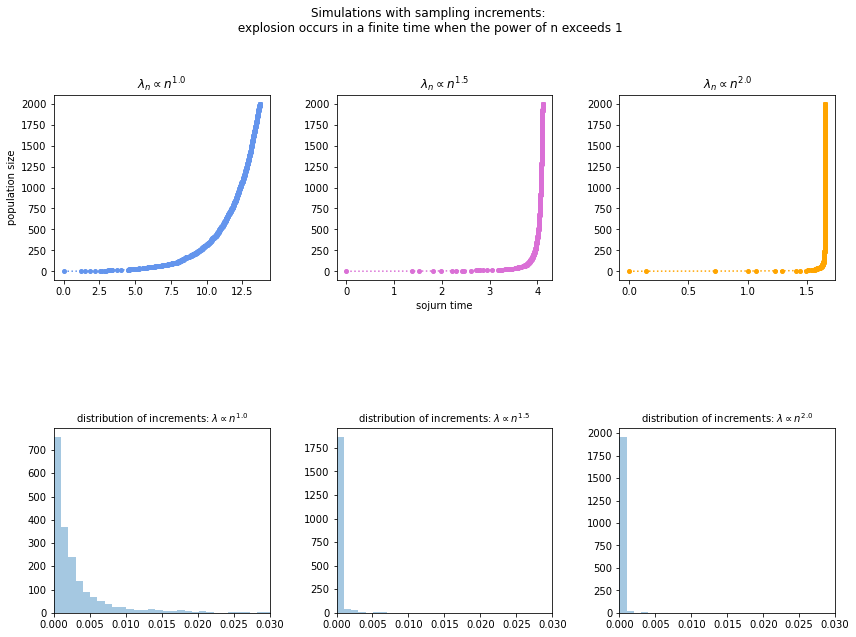

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import scipy.special
from matplotlib.lines import Line2D 
import seaborn as sns
from cycler import cycler

np.random.seed(0)
  
def increment_sampling(b, N, P0, d, n_sim):
    
    """
    b = birth_rate
    N = max population 
    P0 = initial population 
    n_sim = number of simulations
    d = degree of population growth. 
    """
        
    s = np.zeros((n_sim, N))  # sojurn times
    X1 = np.zeros((n_sim, N)) # population matrix
    inc = np.zeros((n_sim,N))
    X1[:,0] = P0

    for j in range(n_sim):
        for i in range(N-1):
            U = np.random.uniform(0,1)
            h = - np.log(U)/(b*X1[j,i]**d)  # time incerements
            inc[j,i] = h
            s[j,i+1] = s[j,i] + h
            X1[j,i+1] = X1[j,i] + 1 
      
    
    return [s, X1, inc]
    
    
def plots(b, N, P0, deg, num_sim):
    
    fig, ax = plt.subplots(2,3,figsize=(12,8))
    marker_style = dict(linestyle=':',marker='o', markersize=4) 
    col = ['cornflowerblue', 'orchid', 'orange']
    
   
    
    for i, d in enumerate(deg):
        
        [s, X1, inc] = increment_sampling(b, N, P0, d, n_sim)
        ax[0,i].plot(s[0,:], X1[0,:], color=col[i], **marker_style)
        sns.distplot(inc, ax=ax[1,i], bins=np.linspace(0,0.1,100), kde=False)
        ax[0,i].set_title('$\lambda_{n}\propto n^{%1.1f}$'%d)
        ax[1,i].set_title('distribution of increments: $\lambda\propto n^{%1.1f}$'%d, fontsize=10)
        ax[0,0].set_ylabel('population size',fontsize=10)
        ax[0,1].set_xlabel('sojurn time',fontsize=10)
        ax[1,i].set_xlim([0,0.03])
        plt.suptitle('Simulations with sampling increments:\n explosion occurs'\
                     ' in a finite time when the power of n exceeds 1', y=1.1)  
        plt.tight_layout(h_pad=10,w_pad=2)
        
b = 0.5
N = 2000
P0 = 1
deg = [1, 1.5, 2]
n_sim = 1

plots(b, N, P0, deg, n_sim)

In the second method, tau-leaping method, we use some kind of generalized Euler method, where we update the population size using
$$ X(t+\tau)-X(t)=Poisson(b\,\tau).$$
Obviousely in this case we have jumps and the plot $X(t)$ vs $t$ becomes piecewise linear. To make the plot smoother, we can sample on a large number and then take the average. In the next cell, I have simulated the process by using this method and have compared the result with the exat mean which is the soluation of 

$$ \frac{d}{dt}E[X(t)] = b\,E[X(t)^{d}].$$

for this simulation, I have used the linear growth, $d=1$ and hence the excat mean is

$$ E[X(t)] = e^{b\,t}$$

I have used $\tau = 0.01$ and have tried 1000 steps, therefore the max-time is 10. Moreove similar to the pervious cell, I have used $b=0.5$.

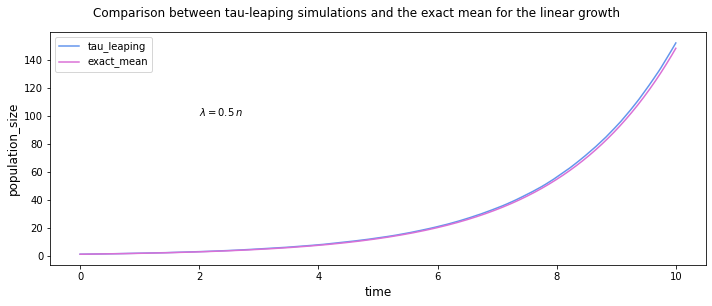

In [55]:
def tau_leaping(b, tau, P0, n_steps, n_sim):
    
    """
    b = birth_rate
    n_steps = number of steps
    P0 = initial population 
    n_sim = number of simulations
    d = degree of population growth. 
    """
    X2 = np.zeros((n_sim, n_steps))  # population matrix
    X2[:,0] = P0

    for j in range(n_sim):
        for i in range(n_steps-1):
            r = np.random.poisson(lam = b*X2[j,i]*tau)
            X2[j,i+1] = X2[j,i] + r
            
    X2_aver = np.mean(X2, axis=0)
                
    return [X2, X2_aver]  


def exact_mean(b, P0, t):
    
    y =  P0*np.exp(b*t)
    return y        

    
def tau_leaping_plots(b, tau, P0, n_steps, n_sim):
    
    fig, ax = plt.subplots(1,figsize=(10,4))
    plt.suptitle('Comparison between tau-leaping simulations'\
                 ' and the exact mean for the linear growth', y=1.05)  
    col = ['cornflowerblue', 'orchid']
   
    [X2, X2_aver] = tau_leaping(b, tau, P0, n_steps, n_sim)
    t = np.linspace(0, tau*n_steps, n_steps)
    y = exact_mean(b, P0, t)
    ax.plot(t, X2_aver, color=col[0], label='tau_leaping')
    ax.plot(t, y, color=col[1], label='exact mean')
    ax.text(2,100, r"$\lambda = 0.5\,n$", style = 'italic' , size=10)
    ax.legend(['tau_leaping', 'exact_mean'])
    ax.set_xlabel('time',fontsize=12)
    ax.set_ylabel('population_size',fontsize=12)  
    plt.tight_layout()
    
b = 0.5
tau = 0.01
P0 = 1 
n_steps = 1000
n_sim = 1000
  
tau_leaping_plots(b, tau, P0, n_steps, n_sim)    

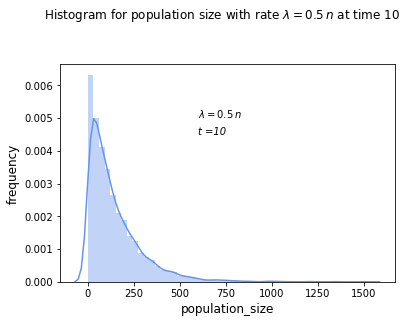

In [56]:
def tau_leaping_hist(b, tau, P0, n_steps, n_sim):
    
    fig, ax = plt.subplots()
    plt.suptitle(r'Histogram for population size with rate $\lambda=0.5\,n$ at time 10',\
                 va='center', ha='center',y=1.05) 
    col = ['cornflowerblue', 'orchid']
   
    [X2, X2_aver] = tau_leaping(b, tau, P0, n_steps, n_sim)
    sns.distplot(X2[:,n_steps-1], color=col[0], label='tau_leaping')
    ax.text(600,0.005, r"$\lambda = 0.5\,n$", style = 'italic' , size=10)
    ax.text(600,0.0045, "t =10", style = 'italic' , size=10)
    ax.set_xlabel('population_size',fontsize=12)
    ax.set_ylabel('frequency',fontsize=12)
       
    
b = 0.5
tau = 0.01
P0 = 1 
n_steps = 1000
n_sim = 10000


tau_leaping_hist(b, tau, P0, n_steps, n_sim)